In [3]:
import os
%env OPENAI_API_KEY=token
%env REPLICATE_API_TOKEN=token
#%env ROS_MASTER_URI=localhost
print(os.environ.get("OPENAI_API_KEY"))

env: OPENAI_API_KEY=token
env: REPLICATE_API_TOKEN=token
token


[INFO] [1745725392.649389, 47.300000]: Waiting for joint trajectory action on /locobot/arm_controller/follow_joint_trajectory…
[INFO] [1745725393.088850, 47.700000]: Joint‐space action server ready
[INFO] [1745725393.175242542]: Loading robot model 'locobot'...
[INFO] [1745725393.175271192]: No root/virtual joint specified in SRDF. Assuming fixed joint
[INFO] [1745725394.681855251, 49.278000000]: Ready to take commands for planning group interbotix_arm.
[INFO] [1745725394.838722, 49.279000]: LocobotArmControl initialized


[WARN] [1745725393.173423786]: Link 'locobot/caster_back_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745725393.174168159]: Link 'locobot/caster_front_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745725393.174193319]: Link 'locobot/wheel_left_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745725393.174206399]: Link 'locobot/wheel_right_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745725393.174221829]: Link 'locobot/caster_back_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745725393.174233669]: Link 'locobot/caster_front_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745725393.174249349]: Link 'locobot/wheel_left_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745725393.174260329]: Link 'locobot/wheel_right_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745725393.174280029]: Link 'locobot/caster_back

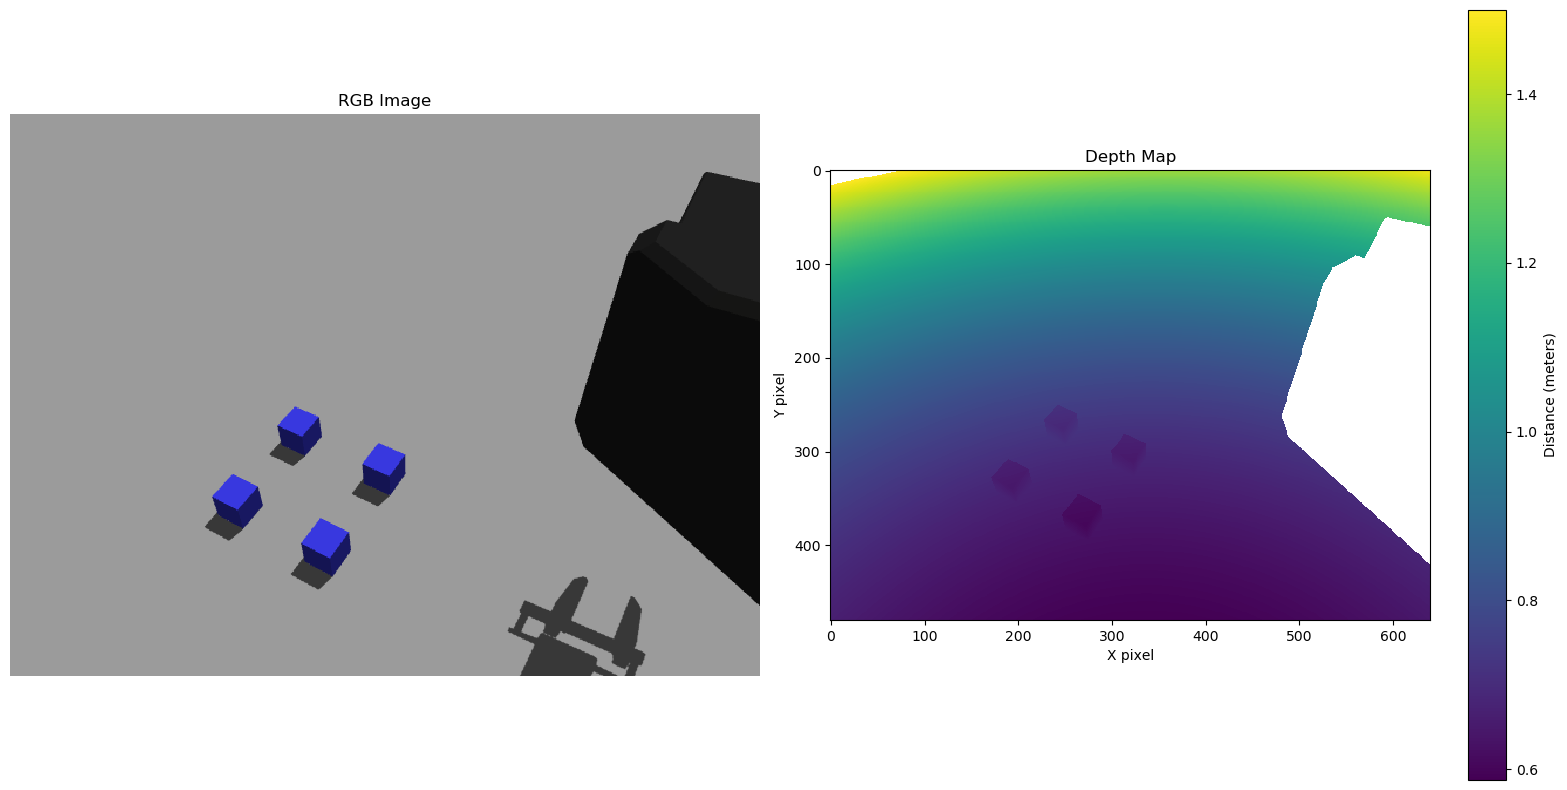

Using OpenAI API with model gpt-4o
Sending prompt to OpenAI...
Base response received.
To construct the given house-like structure:

1. **Base of the house (square):** Let's place this on the coordinate grid.
2. **Roof (triangle):** Place it on top of the square.

### Deconstructed Build

1. **Square Base:**
   - Bottom-left corner of the square at (3, 0).
   - Width and height: 4x4 to fit within a 10x10 grid.

2. **Triangle Roof:**
   - Base of the triangle aligns with the top of the square at (3, 4).
   - Height: 2 (extends from (3, 4) to (7, 6)).
   
### Steps to Build

Assuming the grid coordinates of the blocks in the environment are:

- Bottom-left block: (0, 0)
- Bottom-right block: (1, 0)
- Top-left block: (0, 1)
- Top-right block: (1, 1)

#### Step-by-step Instructions:

1. **ACTION 1:** 
   - `{ pos_init: {x: 0, y: 0}, pos_finale: {x: 3, y: 0}, notice: "Place the bottom-left block of the square base, approach from the top." }`
   
2. **ACTION 2:** 
   - `{ pos_init: {x: 1, y:

[WARN] [1745725487.247409031, 139.217000000]: Fail: ABORTED: TIMED_OUT
[WARN] [1745725487.321741, 139.282000]: MoveIt planning failed


X: 248, Y: 271
Distance: nan m
Action: {'pos_init': {'x': 42.3, 'y': 76.9}, 'pos_finale': {'x': 3, 'y': 4}, 'notice': 'Place the bottom block of the roof, align with the top of the square, approach from the top.'}
[INFO] [1745725526.484825614, 177.268000000]: ABORTED: CONTROL_FAILED
X: 270, Y: 369
Distance: 0.629422437530482 m
Action: {'pos_init': {'x': 50.2, 'y': 62.6}, 'pos_finale': {'x': 5, 'y': 5}, 'notice': 'Place the final block of the roof, creating the peak, approach from the top.'}
X: 321, Y: 300
Distance: 0.5238517064071398 m


In [2]:
#source devel/setup.bash
#roslaunch locobot_connector cube_spawner.launch num_cubes:=4 positions:=[[0.30,0.25,0.01],[0.30,0.35,0.01],[0.4,0.25,0.01],[0.4,0.35,0.01]]
import numpy as np
import matplotlib.pyplot as plt
from visioncraft.locobot.camera import LocobotCamera
from visioncraft.locobot.arm_control import LocobotArmControl
import rospy
from visioncraft.vlm.vlm_pipeline import VLMPipeline
import os

def visualize_depth_map(cam, min_distance=0.5, max_distance=1.5):
    """
    Create a depth map visualization and show the RGB image using matplotlib
    """
    # Get the image
    img = cam.get_image()
    if img is None:
        print("No image received")
        return
        
    height, width = img.shape[:2]
    
    # Create depth map
    depth_map = np.full((height, width), np.nan)
    
    # Fill depth map with distances
    for y in range(height):
        for x in range(width):
            point = cam.get_point_at_pixel(x, y)
            if point is not None:
                # Calculate distance from camera (Euclidean distance)
                distance = np.sqrt(point[0]**2 + point[1]**2 + point[2]**2)
                if min_distance <= distance <= max_distance:
                    depth_map[y, x] = distance  # Only keep valid distances
    
    # Create visualization
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot RGB image
    axs[0].imshow(img)
    axs[0].set_title('RGB Image')
    axs[0].axis('off')
    

    # Plot depth map
    depth_plot = axs[1].imshow(depth_map, cmap='viridis')
    axs[1].set_title('Depth Map')
    axs[1].set_xlabel('X pixel')
    axs[1].set_ylabel('Y pixel')
    fig.colorbar(depth_plot, ax=axs[1], label='Distance (meters)')
    
    plt.tight_layout()
    plt.show()

def get_depth_map(cam, min_distance=0.5, max_distance=1.5):
    """
    Get the depth map from the camera
    """
    # Get the image
    img = cam.get_image()
    if img is None:
        print("No image received")
        return
        
    height, width = img.shape[:2]
    
    # Create depth map
    depth_map = np.full((height, width), np.nan)
    
    # Fill depth map with distances
    for y in range(height):
        for x in range(width):
            point = cam.get_point_at_pixel(x, y)
            if point is not None:
                # Calculate distance from camera (Euclidean distance)
                distance = np.sqrt(point[0]**2 + point[1]**2 + point[2]**2)
                if min_distance <= distance <= max_distance:
                    depth_map[y, x] = distance  # Only keep valid distances
    
    return depth_map, height, width

def pick_block_action(action, cam, arm_control):
    print(f"Action: {action}")
    pos_init = action['pos_init']
    depth_map, height, width = get_depth_map(cam)
    x = int(pos_init["x"]/100 * width)
    y = int(pos_init["y"]/100 * height)
    go_to_pos(cam, arm_control, x, y)
    print(f"X: {x}, Y: {y}")
    if depth_map[y, x] is not None:
        print(f"Distance: {depth_map[y, x]} m")
    else:
        print("No valid distance found at this pixel.")

def go_to_pos(cam,arm_control, x, y):

    img = cam.get_image()

    point_camera = cam.get_point_at_pixel(x, y)
    point_base = cam.get_target_coordinate_from_camera(point_camera)
    arm_control.pick(point_base)

def place_block_action(action, cam):
    print(f"Action: {action}")
    pass

def main():
    cam = LocobotCamera()
    arm_control = LocobotArmControl()

    cam.pan(0.5)
    cam.tilt(0.8)
    img = cam.get_image()
        
    # Visualize depth map and image
    visualize_depth_map(cam)
    plt.imsave('../resources/rgb_image.png', img)

    vlm_pipeline = VLMPipeline(model_name="gpt-4o", openai_api_key=os.environ.get("OPENAI_API_KEY"))
    vlm_pipeline.set_current_image("../resources/rgb_image.png")
    vlm_pipeline.set_goal_image("../resources/simple_house.png")
    json_answer = vlm_pipeline.run_pipeline()
    for actions in json_answer:
            for action in json_answer[actions]:
                # Each action to accomplish
                pick_block_action(action, cam, arm_control)
                

    # Wait for some data to be received
    rospy.sleep(1.0)


if __name__ == '__main__':
    main()
